In [253]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [254]:
data = np.genfromtxt("data/2021IndexPredictions.txt", delimiter=", ", skip_header=1, invalid_raise=False)
with open('data/2021IndexPredictions.txt') as f:
    firstLine = f.readline().strip()
    headers = firstLine.split(", ")
headers = headers[1:]
lenHeaders = len(headers)
# Eliminates Comoros, Fiji and Guinea-Bissau
data = np.asarray([row[1:] for row in data if not any(np.isnan(x) for x in row[1:])])
print(data)

[[0.8125     0.76666667 0.60416667 0.71742424 0.83475379 0.75      ]
 [0.17801471 0.10238095 0.         0.20857143 0.0985119  0.        ]
 [0.39904221 0.69512987 0.19642857 0.53051948 0.35795455 0.        ]
 ...
 [0.10702206 0.09725275 0.         0.23351648 0.05975275 0.        ]
 [0.58642857 0.66493506 0.28409091 0.38961039 0.4549513  0.34090909]
 [0.24083117 0.34155844 0.         0.07662338 0.14813312 0.04545455]]


In [255]:
# df = pd.Series()
columns = data.T
X_train, X_test, y_train, y_test = train_test_split(data[:, 1:], columns[1], test_size=0.2)
clf = Lasso(alpha=1)
clf.fit(X_train, y_train)
r_squared = r2_score(clf.predict(X_test), y_test)
print(r_squared)
print(clf.coef_)


-4.45645828618207e+30
[0. 0. 0. 0. 0.]


In [256]:
clf = Ridge(alpha=1)
clf.fit(X_train, y_train)
r_squared = r2_score(clf.predict(X_test), y_test)
print(r_squared)
print(clf.coef_)

0.9681113221383829
[0.76474478 0.01902319 0.01515842 0.06519368 0.05285986]


In [257]:
clf = LinearRegression()
clf.fit(X_train, y_train)
r_squared = r2_score(clf.predict(X_test), y_test)
print(r_squared)
print(clf.coef_)

1.0
[ 1.00000000e+00 -9.96339425e-17 -2.65212082e-16  2.75565036e-16
  2.06483613e-16]


In [258]:
ridgeSimMatrix = [headers.copy()]
for x in range(lenHeaders):
    X_train, X_test, y_train, y_test = train_test_split(np.asarray([row for i,row in enumerate(columns) if i!=x]).T, columns[x], test_size=0.2)
    clf = Ridge(alpha=1)
    clf.fit(X_train, y_train)
    ridgeSimRow = [ridgeSimMatrix[0][x]]
    coefs = list(clf.coef_)
    for i in range(lenHeaders-1):
        if x <= i:
            ridgeSimRow.append(coefs[i])
        else:
            ridgeSimRow.append(ridgeSimMatrix[i+1][x])
    ridgeSimMatrix.append(ridgeSimRow)
for i in range(lenHeaders+1):
    ridgeSimMatrix[i].insert(i, 1)
ridgeMatrixFramed = pd.DataFrame(ridgeSimMatrix)
print(ridgeMatrixFramed)

    0         1         2         3         4         5         6
0   1        VA        PV        GE        RQ        RL        CC
1  VA         1  0.292718  0.151005  0.156450  0.141853  0.101677
2  PV  0.292718         1  0.039775 -0.010699  0.200723  0.176403
3  GE  0.151005  0.039775         1  0.270324  0.426706  0.194387
4  RQ  0.156450 -0.010699  0.270324         1  0.281942 -0.010694
5  RL  0.141853  0.200723  0.426706  0.281942         1  0.203351
6  CC  0.101677  0.176403  0.194387 -0.010694  0.203351         1


In [259]:
lassoSimMatrix = [headers.copy()]
for x in range(lenHeaders):
    X_train, X_test, y_train, y_test = train_test_split(np.asarray([row for i,row in enumerate(columns) if i!=x]).T, columns[x], test_size=0.2)
    clf = Lasso(alpha=1)
    clf.fit(X_train, y_train)
    lassoSimRow = [lassoSimMatrix[0][x]]
    coefs = list(clf.coef_)
    for i in range(lenHeaders-1):
        if x <= i:
            lassoSimRow.append(coefs[i])
        else:
            lassoSimRow.append(lassoSimMatrix[i+1][x])
    lassoSimMatrix.append(lassoSimRow)
for i in range(lenHeaders+1):
    lassoSimMatrix[i].insert(i, 1)
lassoMatrixFramed = pd.DataFrame(lassoSimMatrix)
print(lassoMatrixFramed)

    0    1    2    3    4    5    6
0   1   VA   PV   GE   RQ   RL   CC
1  VA    1  0.0  0.0  0.0  0.0  0.0
2  PV  0.0    1  0.0  0.0  0.0  0.0
3  GE  0.0  0.0    1  0.0  0.0  0.0
4  RQ  0.0  0.0  0.0    1  0.0  0.0
5  RL  0.0  0.0  0.0  0.0    1  0.0
6  CC  0.0  0.0  0.0  0.0  0.0    1


In [260]:
linRegSimMatrix = [headers.copy()]
for x in range(lenHeaders):
    X_train, X_test, y_train, y_test = train_test_split(np.asarray([row for i,row in enumerate(columns) if i!=x]).T, columns[x], test_size=0.2)
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    linRegSimRow = [linRegSimMatrix[0][x]]
    coefs = list(clf.coef_)
    for i in range(lenHeaders-1):
        if x <= i:
            linRegSimRow.append(coefs[i])
        else:
            linRegSimRow.append(linRegSimMatrix[i+1][x])
    linRegSimMatrix.append(linRegSimRow)
for i in range(lenHeaders+1):
    linRegSimMatrix[i].insert(i, 1)
linRegMatrixFramed = pd.DataFrame(linRegSimMatrix)
print(linRegMatrixFramed)

    0         1         2         3         4         5         6
0   1        VA        PV        GE        RQ        RL        CC
1  VA         1  0.362090  0.097063  0.270242  0.116177  0.069534
2  PV  0.362090         1  0.033671  0.011446  0.166173  0.151040
3  GE  0.097063  0.033671         1  0.261761  0.537442  0.219825
4  RQ  0.270242  0.011446  0.261761         1  0.310235 -0.118858
5  RL  0.116177  0.166173  0.537442  0.310235         1  0.167157
6  CC  0.069534  0.151040  0.219825 -0.118858  0.167157         1


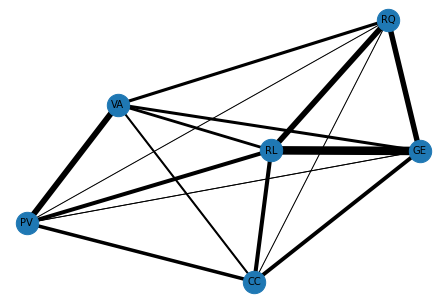

In [261]:
adjMatrix = [[x*20 if i < j else 0 for j, x in enumerate(row)] for i, row in enumerate(np.asarray(ridgeSimMatrix)[1:, 1:].astype(np.float))]
G = nx.from_numpy_matrix(np.matrix(adjMatrix))

layout = nx.spring_layout(G)
lab_node = dict(zip(G.nodes, headers))
nx.draw(G, layout)
nx.draw_networkx_nodes(G, layout, node_size=500)
widths = list(nx.get_edge_attributes(G, "weight").values())
nx.draw_networkx_edges(G, layout, width=widths)
nx.draw_networkx_labels(G, layout, labels=lab_node, font_size=10, font_family='sans-serif')
plt.show()

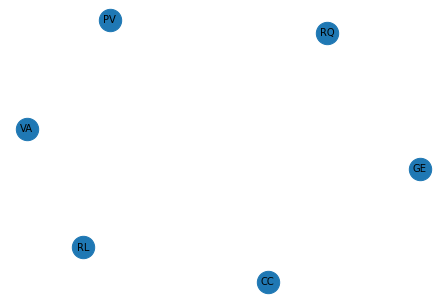

In [262]:
adjMatrix = [[x*20 if i < j else 0 for j, x in enumerate(row)] for i, row in enumerate(np.asarray(lassoSimMatrix)[1:, 1:].astype(np.float))]
G = nx.from_numpy_matrix(np.matrix(adjMatrix))

layout = nx.spring_layout(G)
lab_node = dict(zip(G.nodes, headers))
nx.draw(G, layout)
nx.draw_networkx_nodes(G, layout, node_size=500)
widths = list(nx.get_edge_attributes(G, "weight").values())
nx.draw_networkx_edges(G, layout, width=widths)
nx.draw_networkx_labels(G, layout, labels=lab_node, font_size=10, font_family='sans-serif')
plt.show()

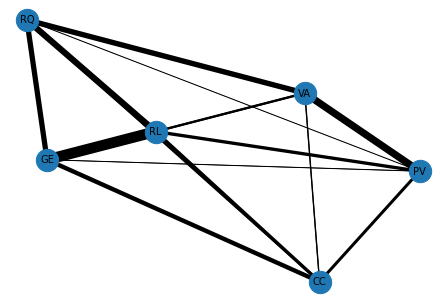

In [263]:
adjMatrix = [[x*20 if i < j else 0 for j, x in enumerate(row)] for i, row in enumerate(np.asarray(linRegSimMatrix)[1:, 1:].astype(np.float))]
G = nx.from_numpy_matrix(np.matrix(adjMatrix))

layout = nx.spring_layout(G)
lab_node = dict(zip(G.nodes, headers))
nx.draw(G, layout)
nx.draw_networkx_nodes(G, layout, node_size=500)
widths = list(nx.get_edge_attributes(G, "weight").values())
nx.draw_networkx_edges(G, layout, width=widths)
nx.draw_networkx_labels(G, layout, labels=lab_node, font_size=10, font_family='sans-serif')
plt.show()